In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, '../')
from toolkit import trappist1, transit_model, trappist_out_of_transit

g = trappist1('g')

In [3]:
bjd, flux, err, model, spotinds = np.loadtxt('g_lcbest.txt', unpack=True)

transit_model_g = transit_model(bjd, g)

In [65]:
import celerite
from celerite import terms
from scipy.optimize import minimize
from celerite.modeling import Model
from copy import deepcopy

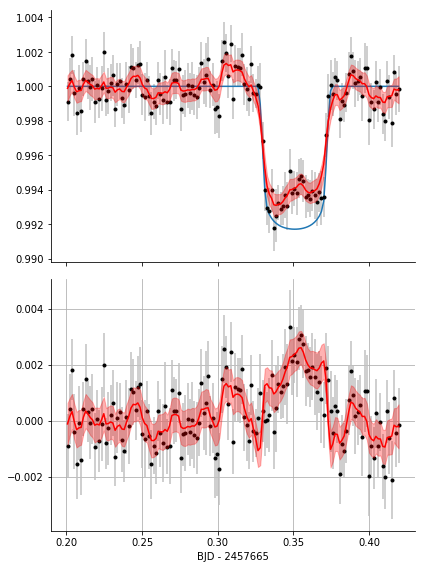

In [71]:
class MeanModelNoSpot(Model):
    def get_value(self, t):
        return transit_model(t, trappist1('g'))

times = bjd
fluxes = flux
original_params = g
errors = err

mean_model_spotless = MeanModelNoSpot()

bounds = dict(log_a=(-30, 30))#, log_c=(np.log(4), np.log(8)))

log_c_median = 1.98108915

kernel = terms.RealTerm(log_a=-10, log_c=log_c_median,
                        bounds=bounds)
#kernel.freeze_parameter('log_c')

gp = celerite.GP(kernel, mean=mean_model_spotless, fit_mean=True)
gp.compute(times - original_params.t0, errors)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(fluxes, gp))
gp.set_parameter_vector(soln.x)
gp.compute(times - original_params.t0, errors)
soln_nospots = soln.x
final_lnlikelihood_nospots = gp.log_likelihood(fluxes)

mu, var = gp.predict(fluxes, times - original_params.t0, return_var=True)
std = np.sqrt(var)

#final_lnlikelihood_nospots = 0.5 * np.sum((transit_model_g - fluxes)**2 / errors**2)

tmid = int(times.mean())
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax[0].errorbar(times - tmid, fluxes, errors, fmt='.', color='k', ecolor='silver')
ax[0].fill_between(times - tmid, mu-std, mu+std, color='r', zorder=10, alpha=0.3)
ax[0].plot(times - tmid, mu, color='r', zorder=10)
ax[0].plot(bjd - tmid, transit_model_g)

ax[1].errorbar(times - tmid, fluxes - transit_model_g, errors, fmt='.', color='k', ecolor='silver')
ax[1].fill_between(times - tmid, mu-std-transit_model_g, mu+std-transit_model_g, color='r', zorder=10, alpha=0.3)
ax[1].plot(times - tmid, mu - transit_model_g, color='r', zorder=10)
ax[1].grid()
ax[1].set_xlabel('BJD - {0}'.format(tmid))
for axis in ax: 
    for j in ['right', 'top']:
        axis.spines[j].set_visible(False)

fig.tight_layout()
fig.savefig('gp.png', dpi=200, bbox_inches='tight')

In [72]:
mu[max_ind], (1-transit_model_g[max_ind])

(0.99434509526951143, 0.0082645566278750637)

In [73]:
max_ind = np.argmax(mu - transit_model_g) 

spot_contrast = (mu[max_ind] - transit_model_g[max_ind]) / (1-transit_model_g[max_ind])

spot_contrast

0.31576429503605058

In [74]:
from astropy.modeling.blackbody import blackbody_lambda
import astropy.units as u

wl, trans = np.loadtxt('../toolkit/data/filters/Spitzer_IRAC.I2.txt', unpack=True)
wl /= 10000
wl = wl * u.um
#plt.plot(wl, trans)

photosphere = blackbody_lambda(wl, 2511).value

def contrast_model(p):
    dark_spot = blackbody_lambda(wl, p[0]).value
    
    return 1 - np.trapz(dark_spot, wl.value) / np.trapz(photosphere, wl.value)

def minimize_this(p):
    return abs(contrast_model(p) - spot_contrast)

from scipy.optimize import fmin_powell

contrast_model([2110])
result = fmin_powell(minimize_this, [2110])
print("Best spot temperature: {} K".format(result))

2511 - result

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 176
Best spot temperature: 2059.2045952521853 K


451.7954047478147

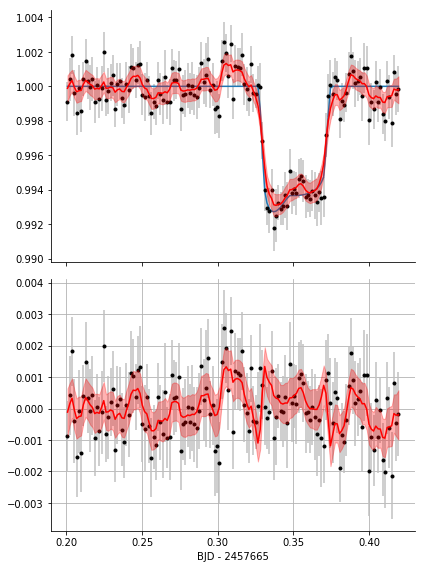

In [68]:
class MeanModelSTSP(Model):
    def get_value(self, t):
        return np.interp(t, bjd, model)

mean_model_stsp = MeanModelSTSP()

kernel = terms.RealTerm(log_a=-20, log_c=log_c_median,
                        bounds=bounds)

gp = celerite.GP(kernel, mean=mean_model_stsp, fit_mean=True)
gp.compute(times - original_params.t0, errors)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, #jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(fluxes, gp))
gp.set_parameter_vector(soln.x)
soln_stsp = soln.x
gp.compute(times - original_params.t0, errors)

#final_lnlikelihood_stsp = gp.log_likelihood(fluxes)

final_lnlikelihood_stsp = 0.5 * np.sum((mu - fluxes)**2 / errors**2)

mu, var = gp.predict(fluxes, times - original_params.t0, return_var=True)
std = np.sqrt(var)

tmid = int(times.mean())
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax[0].errorbar(times - tmid, fluxes, errors, fmt='.', color='k', ecolor='silver')
ax[0].fill_between(times - tmid, mu-std, mu+std, color='r', zorder=10, alpha=0.3)
ax[0].plot(times - tmid, mu, color='r', zorder=10)
ax[0].plot(bjd - tmid, model)

ax[1].errorbar(times - tmid, fluxes - model, errors, fmt='.', color='k', ecolor='silver')
ax[1].fill_between(times - tmid, mu-std-model, mu+std-model, color='r', zorder=10, alpha=0.3)
ax[1].plot(times - tmid, mu - model, color='r', zorder=10)
ax[1].grid()
ax[1].set_xlabel('BJD - {0}'.format(tmid))
for axis in ax: 
    for j in ['right', 'top']:
        axis.spines[j].set_visible(False)

fig.tight_layout()
fig.savefig('gp_spots.png', dpi=200, bbox_inches='tight')

In [69]:
final_lnlikelihood_nospots, final_lnlikelihood_stsp

(73.503074548130897, 28.85546930842548)